In [6]:
import os
import shutil
import re


In [7]:
# Caminhos das pastas originais
orig_base = 'DataSet'
orig_no_dr = os.path.join(orig_base, 'Healthy')
orig_with_dr = os.path.join(orig_base, 'Diabetic Retinopathy')

# Caminhos das pastas destino
dest_base = 'dataset_selecionado'
dest_no_dr = os.path.join(dest_base, 'no_DR')
dest_with_dr = os.path.join(dest_base, 'with_DR')

# Cria pastas destino se não existirem
os.makedirs(dest_no_dr, exist_ok=True)
os.makedirs(dest_with_dr, exist_ok=True)
# Define número de imagens por classe

n_images = 400

In [8]:
# Função para limpar pasta destino
def limpar_pasta(pasta):
    if os.path.exists(pasta):
        for f in os.listdir(pasta):
            file_path = os.path.join(pasta, f)
            if os.path.isfile(file_path):
                os.unlink(file_path)
    else:
        os.makedirs(pasta)

In [9]:
# Função para extrair número do nome do arquivo
def extrair_numero(nome_arquivo):
    numeros = re.findall(r'\d+', nome_arquivo)
    return int(numeros[0]) if numeros else -1

# Função para copiar imagens ordenadas numericamente
def copiar_imagens(orig_path, dest_path, n):
    imagens = [img for img in os.listdir(orig_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    imagens.sort(key=extrair_numero)  # ordena numericamente
    imagens_selecionadas = imagens[:min(n, len(imagens))]

    for img in imagens_selecionadas:
        src = os.path.join(orig_path, img)
        dst = os.path.join(dest_path, img)
        shutil.copyfile(src, dst)


# Limpar pastas destino
limpar_pasta(dest_no_dr)
limpar_pasta(dest_with_dr)

# Copiar imagens saudáveis
copiar_imagens(orig_no_dr, dest_no_dr, n_images)

# Copiar imagens não saudáveis
copiar_imagens(orig_with_dr, dest_with_dr, n_images)

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import cv2

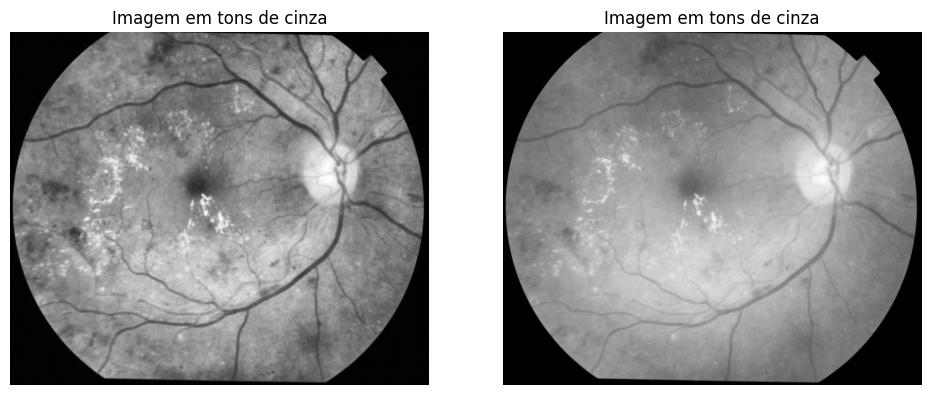

In [15]:
# Abrir a imagem
imagem = Image.open("DR1008.jpg").convert("L")

# Converter PIL para NumPy
img_np = np.array(imagem)

# Converter imagem para array NumPy
pixels = np.array(imagem).flatten()  # Array 1D com todos os pixels

# Criar figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Aplicar CLAHE com OpenCV
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(img_np)

# Converter de volta para imagem PIL (se quiser salvar ou exibir)
imagem_enhanced = Image.fromarray(enhanced)


# Mostrar imagem em tons de cinza
axs[0].imshow(imagem_enhanced, cmap='gray')
axs[0].set_title("Imagem em tons de cinza")
axs[0].axis('off')


# Mostrar imagem em tons de cinza
axs[1].imshow(imagem, cmap='gray')
axs[1].set_title("Imagem em tons de cinza")
axs[1].axis('off')

# Plotar o histograma corretamente
#axs[1].hist(img_np, bins=256, range=(0, 255), color='gray')
#axs[1].set_title("Histograma")
#axs[1].set_xlabel("Intensidade")
#axs[1].set_ylabel("Frequência")




plt.tight_layout()
plt.show()

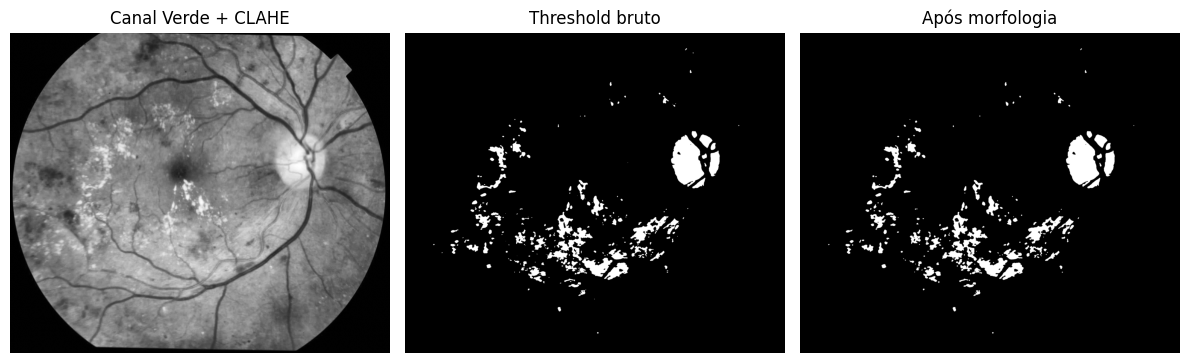

In [18]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Abrir imagem
imagem = Image.open("DR1008.jpg").convert("RGB")
img_np = np.array(imagem)

# Trabalhar no canal verde (melhor contraste para vasos e lesões)
green_channel = img_np[:, :, 1]

# CLAHE no canal verde
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(green_channel)

# Remover o fundo com blur + threshold
blurred = cv2.medianBlur(enhanced, 5)
_, mask = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)

# Operações morfológicas para limpar a imagem
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Visualização
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Canal Verde + CLAHE")
plt.imshow(enhanced, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Threshold bruto")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Após morfologia")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Número de exsudatos detectados: 183
Área total (px): 153742
Tamanho médio (px): 840.120218579235


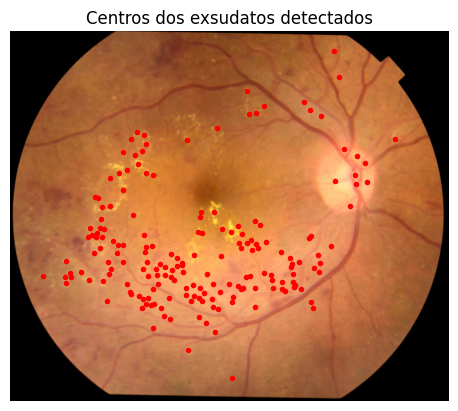

In [20]:
# Dilatar para expandir as regiões
mask_dilated = cv2.dilate(mask_clean, kernel, iterations=1)

# Detectar componentes conectados
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_dilated)

# Ignora o fundo (label 0)
areas = stats[1:, cv2.CC_STAT_AREA]
centros = centroids[1:]

print("Número de exsudatos detectados:", len(areas))
print("Área total (px):", np.sum(areas))
print("Tamanho médio (px):", np.mean(areas))

# Exibir posições dos centróides na imagem original
plt.imshow(img_np)
for cx, cy in centros:
    plt.plot(cx, cy, 'ro', markersize=3)
plt.title("Centros dos exsudatos detectados")
plt.axis('off')
plt.show()
